# Análise de dados

### Grupo: Guilherme Barão, Iran Cruz Soares, Beatriz Evelbauer, Carlos Henrique

*Disciplina: Análise de Regressão*


---



Para essa análise de dados, escolhemos a base de dados _Cars - Purchase Decision Dataset_, disponível em https://www.kaggle.com/datasets/gabrielsantello/cars-purchase-decision-dataset?resource=download

Como essa base de dados traça um perfil socioeconômico dos participantes e depois mostra se compram ou não um carro, percebemos que ela seria ideal para uma regressão logistica. Então, a variável resposta é categórica e vale 0 ou 1 quando a pessoa não compra ou compra o carro, respectivamente.

## Índice<a class='anchor' id='top'></a>
- [Importando Bibliotecas](#bibliotecas)📚
- [Analisando os Dados](#analise)🔍

## Importando Bibliotecas 📚 <a class='anchor' id='bibliotecas'></a> [↑](#top)

In [2]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine
import matplotlib.patches as Patches

## Analisando os Dados 🔍<a class='anchor' id='analise'></a> [↑](#top)

Importando os dados:

In [6]:
dados = pd.read_csv('https://raw.githubusercontent.com/binha0/AnReg/main/car_data.csv')
dados.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


Aqui, identificamos as possíveis covariáveis _Age_, _Gender_ e _AnnualSalary_. _User ID_ é apenas um identificador dos participantes, então não faz sentido ser utilizado na regressão, por isso é removido do data frame.

In [7]:
dados.count()

User ID         1000
Gender          1000
Age             1000
AnnualSalary    1000
Purchased       1000
dtype: int64

Utilizamos a função `count` somente para verificar que não há nenhum dado faltante.

In [8]:
dados.drop(columns=['User ID'], inplace=True)
dados.head()

,Gender,Age,AnnualSalary,Purchased
0,Male,35,20000,0
1,Male,40,43500,0
2,Male,49,74000,0
3,Male,40,107500,1
4,Male,25,79000,0


Aqui, estamos reescrevendo numericamente os dados de _Gender_. Quando o indivíduo é um homem _Gender_ $=1$

In [9]:
dados['NumGender'] = dados['Gender'].replace({'Male':1, 'Female':0})
dados['BoolComprou'] = dados['Purchased'].replace({0:'Não', 1:'Sim'})
dados = dados[['Gender', 'NumGender', 'Age', 'AnnualSalary', 'BoolComprou','Purchased']]
dados.head()

,Gender,NumGender,Age,AnnualSalary,BoolComprou,Purchased
0,Male,1,35,20000,Não,0
1,Male,1,40,43500,Não,0
2,Male,1,49,74000,Não,0
3,Male,1,40,107500,Sim,1
4,Male,1,25,79000,Não,0


Para escolher as covariáveis do modelo, vamos observar a matriz de correlação abaixo.

<ipython-input-73-11c4cbddfd2f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dados.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)


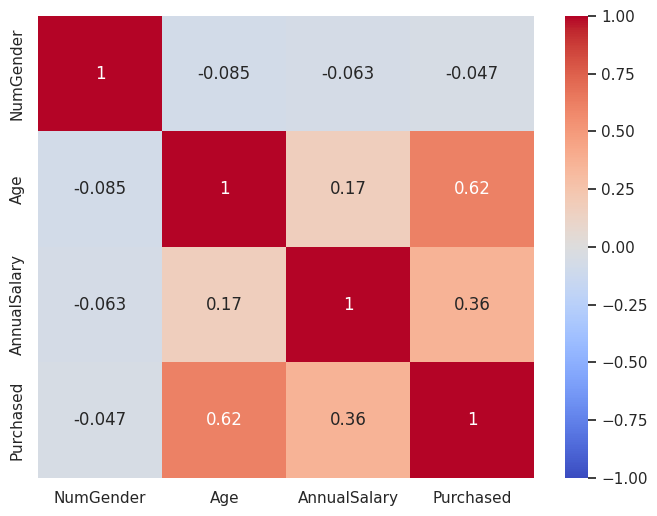

In [73]:
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(dados.corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.show()

Percebemos que principalmente a Idade, mas também o Salário Anual parecem ter correlações significativas com a compra de um carro. Gênero, entretanto, não parece ter relação com a variável resposta.

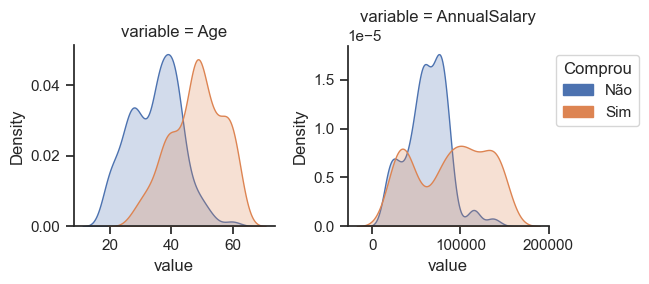

In [ ]:
df = pd.melt(dados, dados.columns[-1], dados.columns[2:-2])

sns.set(style='ticks', color_codes=True)
g = sns.FacetGrid(df, col="variable", hue="Purchased", col_wrap=2, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", fill=True)

labels= dados['BoolComprou'].unique()
colors = sns.color_palette('deep').as_hex()[:len(labels)]
handles = [Patches.Patch(color=col, label=lab) for col,lab in zip(colors, labels)]
plt.legend(handles=handles, title='Comprou', loc='center left', bbox_to_anchor=(1,0.75))

plt.show()

Nesse gráfico, podemos ver que a idade parece ter uma dispersão parecida para os indivíduos que compram e que não compram carros. A diferença maior é a média dos dois, em torno de 30 anos para quem não compra e de 50 para os que compram. Então, percebemos que pessoas mais novas não costumam comprar e pessoas mais velhas o fazem.

O salário anual, entretanto, comporta-se de outra maneira. O salário dos não-compradores se concentra em torno de um valor 'não muito alto' enquanto que o salário dos compradores é mais disperso e apresenta apenas uma queda ao se aproximar do valor médio do outro grupo.

De modo geral, parece que não comprar um carro pode ser explicado por seu salário anual (distribuição azul, concentrada em valores baixos). Contudo as pessoas que compram carros não aparentam ter um padrão salarial bem definido.

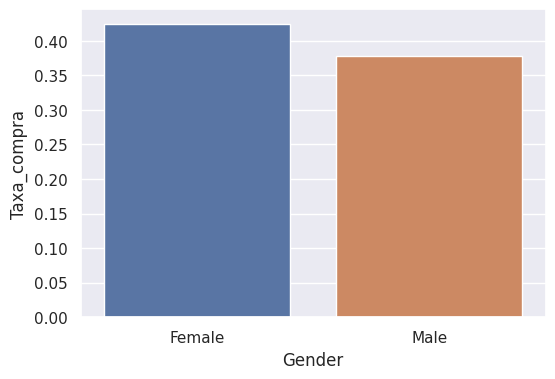

In [16]:
dados_agrupado = dados.groupby('Gender')[['Purchased']].sum()

gender_count = dados['Gender'].value_counts()

dados_agrupado['Taxa_compra'] = dados_agrupado['Purchased'] / gender_count

dados_agrupado.reset_index(inplace=True)
plt.figure(figsize = (6,4))
sns.barplot(data=dados_agrupado, x='Gender', y='Taxa_compra')
plt.show()

Assim como as observações da correlação, esse barplot indica que não há uma relação forte entre gênero e a compra de um carro.

## Aplicando e interpretando a Regressão 📈<a class='anchor' id='regressao'></a> [↑](#top)

Como a idade é a covariável mais correlacionada com a variável resposta e seu gráfico de densidades parece distinguir melhor compradores e não-compradores, essa será a primeira covariável incluída no modelo:

In [18]:
regressao = smf.glm('Purchased ~ Age', data=dados, family=sm.families.Binomial()).fit()

print(regressao.summary())
print(f'Deviance normalizado: {regressao.deviance / regressao.df_resid} \nAIC: {regressao.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -443.18
Date:                Mon, 10 Jul 2023   Deviance:                       886.37
Time:                        19:34:07   Pearson chi2:                     986.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3695
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9665      0.500    -15.923      0.0

Note que a estatística `Pseudo R-squ` é de $0.3965$, ou seja, ainda podemos melhorar o modelo, mesmo que a regressão seja significativa, fato indicado pelo Deviance menor que 1 e p-valores baixos.

<Axes: xlabel='Age', ylabel='Purchased'>

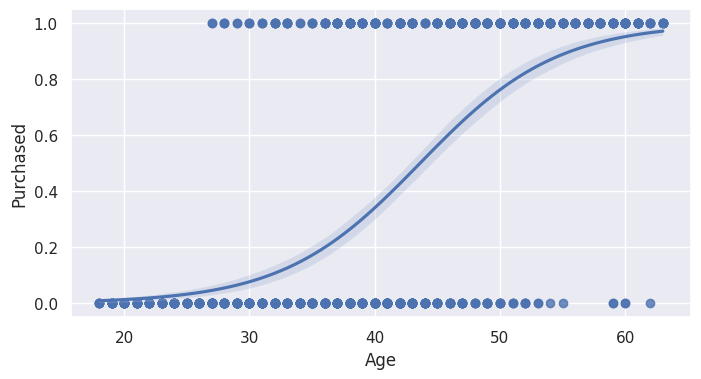

In [19]:
plt.figure(figsize = (8,4))
sns.regplot(data=dados, x='Age', y='Purchased', logistic=True)

Para a segunda covariável inclusa, escolhemos o salário anual, porque ainda tem uma correlação significativa e parece identificar bem os não-compradores.

In [42]:
regressao2 = smf.glm('Purchased ~ Age + AnnualSalary', data=dados, family=sm.families.Binomial()).fit()

print(regressao2.summary())
print(f'Deviance normalizado: {regressao2.deviance / regressao2.df_resid} \nAIC: {regressao2.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -372.97
Date:                Mon, 10 Jul 2023   Deviance:                       745.93
Time:                        20:28:26   Pearson chi2:                 1.08e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4521
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -11.8442      0.769    -15.399   

A segunda covariável aparenta ser significativa também, pois seu p-valor é baixo.

Além disso, o `pseudo-Rsqu` aumentou e tanto AIC quanto Deviance diminuiram em relação ao modelo sem essa covariável.


Adicionando, por fim, a covariável de gênero:

In [36]:
regressao3 = smf.glm('Purchased ~ Age + AnnualSalary + Gender', data=dados, family=sm.families.Binomial()).fit()

print(regressao3.summary())
print(f'Deviance normalizado: {regressao3.deviance / regressao3.df_resid} \nAIC: {regressao3.aic}')


                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -371.48
Date:                Mon, 10 Jul 2023   Deviance:                       742.96
Time:                        20:01:30   Pearson chi2:                 1.07e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4537
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -12.1788      0.805    -15.

Apesar da correlação do gênero ser baixa, o AIC diminuiu o que é um indicativo de que o modelo melhorou, mesmo que pouco.

### Modelos com Interação

Primeiro, vamos testar a interação do _Gender_ com as outras duas covariáveis:

In [37]:
regressao4 = smf.glm('Purchased ~ Age + Gender * AnnualSalary', data=dados, family=sm.families.Binomial()).fit()

print(regressao4.summary())
print(f'Deviance normalizado: {regressao4.deviance / regressao4.df_resid} \nAIC: {regressao4.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -370.88
Date:                Mon, 10 Jul 2023   Deviance:                       741.76
Time:                        20:01:35   Pearson chi2:                 1.08e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4544
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

Como podemos ver, a interação entre gênero e salário não é significativa, a partir dos p-valores. Apesar de o Deviance diminuir, o AIC está aumentando, ou seja, estamos complicando o modelo sem ganhar com isso.

Agora, vamos ver a interação entre idade e salário anual:

In [40]:
regressao5a = smf.glm('Purchased ~ AnnualSalary * Age', data=dados, family=sm.families.Binomial()).fit()

print(regressao5a.summary())
print(f'Deviance normalizado: {regressao5a.deviance / regressao5a.df_resid} \nAIC: {regressao5a.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -299.52
Date:                Mon, 10 Jul 2023   Deviance:                       599.04
Time:                        20:07:57   Pearson chi2:                 2.59e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5270
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -34.0955      2.656  

In [39]:
regressao5 = smf.glm('Purchased ~ Gender + AnnualSalary * Age', data=dados, family=sm.families.Binomial()).fit()

print(regressao5.summary())
print(f'Deviance normalizado: {regressao5.deviance / regressao5.df_resid} \nAIC: {regressao5.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      995
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -295.71
Date:                Mon, 10 Jul 2023   Deviance:                       591.42
Time:                        20:04:31   Pearson chi2:                 2.45e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5306
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -35.6032      2.798  

Note que o AIC e o Deviance diminuiram bastante enquanto o pseudo $R^2$ aumentou, mostrando que a interação é muito significativa. Além disso, a covariável _Gender_ passou a explicar bem a variável resposta quando colocamos a interação.

Agora vamos testar o modelo com interação entre todas as covariáveis:

In [32]:
regressao6 = smf.glm('Purchased ~ Gender * AnnualSalary * Age', data=dados, family=sm.families.Binomial()).fit()

print(regressao6.summary())
print(f'Deviance normalizado: {regressao6.deviance / regressao6.df_resid} \nAIC: {regressao6.aic}')

                 Generalized Linear Model Regression Results                  
Dep. Variable:              Purchased   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      992
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -292.12
Date:                Mon, 10 Jul 2023   Deviance:                       584.24
Time:                        19:59:16   Pearson chi2:                 1.20e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.5339
Covariance Type:            nonrobust                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

O modelo "cheio", apesar de parecer mais complexo, mostra-se significativo pois diminui, em especial, o AIC da regressão. Como o AIC penaliza a adição de novos parâmetros, ele deveria aumentar nesse modelo com todas as interações caso as interações não fossem importantes. Como aconteceu justamente o contrário, as interações são significativas.

### Razão Chance

$\beta_j = \ln(RC) ⇒ RC = e^{\beta_j}$

A razão de chances nos diz qual é a variação da probabilidade de se comprar um carro quando aumentamos em uma unidade cada covariável e cada interação (considerando o modelo mais cheio).

In [59]:
np.exp(regressao6.params[1:])

Gender[T.Male]                     5.717938e-07
AnnualSalary                       1.000234e+00
Gender[T.Male]:AnnualSalary        1.000138e+00
Age                                1.820521e+00
Gender[T.Male]:Age                 1.381716e+00
AnnualSalary:Age                   9.999955e-01
Gender[T.Male]:AnnualSalary:Age    9.999971e-01
dtype: float64

Como não faz sentido falar em RC para o intercepto, calculamos apenas para os demais parâmetros.

Para todas as variáveis, exceto o _Gender_ sem interação, a RC é muito próxima ou maior que 1, então são importantes para o modelo.

Apesar de o RC para _Gender_ ser bem baixo, vimos anteriormente que ele é sim significativo para o modelo por dimiuir o AIC, o Deviance e aumentar o $R^2$.

### Análise de Resíduos

Vamos comparar os resíduos entre o modelo com todas as covariáveis e nenhuma interação com o último modelo obtido, com todas as interações.

count    1.000000e+03
mean     4.020000e-01
std      3.859357e-01
min      3.363361e-10
25%      1.587952e-02
50%      2.662166e-01
75%      8.370010e-01
max      9.999807e-01
dtype: float64

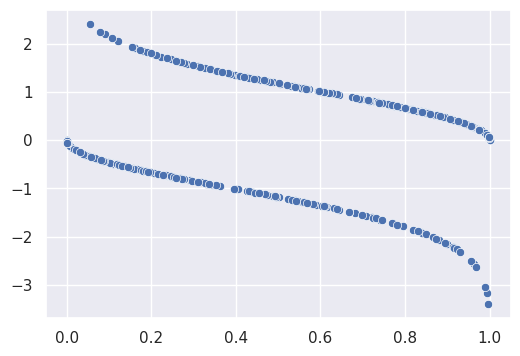

In [71]:
x = dados[['Age', 'AnnualSalary','Gender']]
y_hat = regressao6.predict(x)

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_hat, y=regressao6.resid_deviance)

y_hat.describe()